In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [3]:
def squash(x):
    x_norm = x.pow(2).sum(-1).sqrt().unsqueeze(-1)
    renorm_value = x_norm**2 / (1 + x_norm**2)
    return renorm_value * x / x_norm

![](1.png)

In [91]:
class Routing(nn.Module):
    def __init__(self, IN_CAPS, OUT_CAPS, NUM_ITERATIONS=10):
        super().__init__()
        self.BATCH_SIZE = 64
        self.IN_CAPS = IN_CAPS
        self.OUT_CAPS = OUT_CAPS
        self.NUM_ITERATIONS = NUM_ITERATIONS
        self.c_in = torch.randn(self.BATCH_SIZE, self.IN_CAPS, 2)
        self.c_out = torch.randn(self.BATCH_SIZE, self.OUT_CAPS, 2)
        
        self.W = torch.randn(self.BATCH_SIZE, self.IN_CAPS, self.OUT_CAPS, 2, 2)
        self.b = torch.zeros(self.BATCH_SIZE, self.IN_CAPS, self.OUT_CAPS)

        self.c_out_prediction = (self.W @ self.c_in.unsqueeze(2).unsqueeze(-1)).reshape(self.BATCH_SIZE, self.IN_CAPS, self.OUT_CAPS, 2)

    def dummy_func(self):
        for _ in range(self.NUM_ITERATIONS):
            importance = F.softmax(self.b, dim=-1)
            plt.imshow(importance.numpy().round(1).reshape(5, self.BATCH_SIZE, 3), vmin=0, vmax=1)
            plt.show()
            self.c_out = (importance[:, :, :, None] * self.c_out_prediction).sum(1)
            self.c_out = squash(self.c_out)

            self.similarity = torch.bmm(self.c_out.view(self.BATCH_SIZE, -1, 2), self.c_out_prediction.view(self.BATCH_SIZE, 2, -1)).view(self.BATCH_SIZE,5,3,3)
            self.similarity = torch.diagonal(self.similarity, dim1=-2, dim2=-1)
            self.b = self.b + self.similarity

        return self.c_out, self.b

    def forward(self, x,y):
        return self.dummy_func()


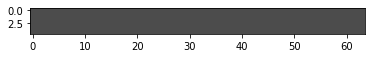

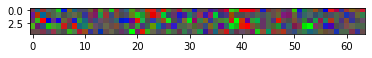

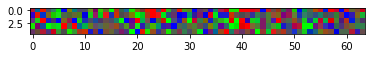

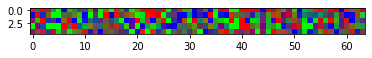

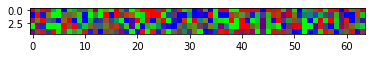

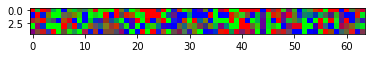

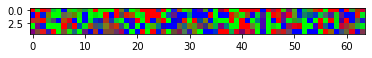

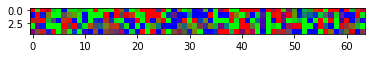

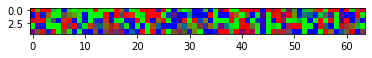

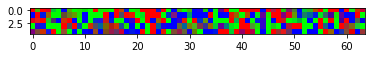

torch.Size([64, 3, 2]) torch.Size([64, 5, 3])


In [92]:
model = Routing(5,3).to(device)
c_out, b = model(5, 3)
print(c_out.shape, b.shape)